In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)


In [2]:
def plot_multiple_line(ax, x, data, color, alpha=0.1, subsample=1, **kwargs):
    num = data.shape[0]
    if type(x) == range:
        avg = np.mean(data, axis=0)
        ax.plot(x[::subsample], avg[::subsample], color=color, **kwargs)
        for i in range(num):
            ax.fill_between(
                x[::subsample],
                data[i, ::subsample],
                avg[::subsample],
                color=color,
                alpha=alpha,
                linewidth=0,
            )

    else:
        mean_x_axis = np.unique(x.ravel())
        ys_interp = [np.interp(mean_x_axis, x[i, :], data[i, :])
                     for i in range(num)]
        avg = np.mean(ys_interp, axis=0)
        ax.plot(mean_x_axis[::subsample],
                avg[::subsample], color=color, **kwargs)

        for i in range(num):
            # ax.plot(x[i], data[i], color=color, alpha=alpha, linewidth=0.5)
            ax.fill_between(
                mean_x_axis[::subsample],
                ys_interp[i][::subsample],
                avg[::subsample],
                color=color,
                alpha=alpha,
                linewidth=0,
            )


In [3]:
sample_batch = 5000


eta = np.linspace(2, 300, 20, dtype=int)
# eta2 = np.logspace(np.log10(10), np.log10(300), 20, dtype=int)
# eta2 = np.unique(np.concatenate([eta1, eta2]))

sample_variance_Relu = np.zeros(len(eta))
sample_mean_Relu = np.zeros([len(eta), 161])

# %% load data, calculate sample variance bias
for i in range(len(eta)):
    H = eta[i]  # maximum length
    grad_sample = np.zeros([sample_batch, 161])

    file_name = "Data/Relu/Pendulum_maximum300_gamma97_grad_H_" + str(int(H)) + ".pt"
    grad_sample = torch.load(file_name)
    print("finish eta = %d\r" % H, end="")
    sample_variance_Relu[i] = np.sum(np.var(grad_sample, axis=0))
    sample_mean_Relu[i, :] = np.mean(grad_sample, axis=0)

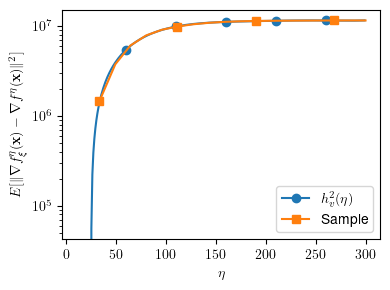

In [4]:
z = np.polyfit(eta[2:], sample_variance_Relu[2:], 6)
poly_var = np.poly1d(z)

plt.figure(figsize=(4, 3))

plt.plot(
    np.arange(10, 300, 1),
    poly_var(np.arange(10, 300, 1)),
    label=r"$h_v^2(\eta)$",
    marker="o",
    markevery=50,
)
plt.plot(eta[2:], sample_variance_Relu[2:],
         label="Sample", marker="s", markevery=5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$E[\|\nabla f^{\eta}_\xi(\mathbf{x})- \nabla f^{\eta}(\mathbf{x})\|^2]$")
plt.yscale("log")
plt.legend()

plt.tight_layout()

plt.savefig("Figure/RL_var_fit.pdf", bbox_inches="tight")


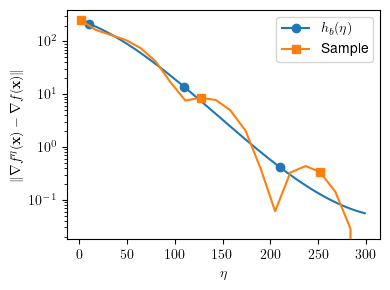

In [5]:
sample_bias_Relu = (
    np.linalg.norm(sample_mean_Relu - sample_mean_Relu[-1, :], axis=1) ** 2
)
z_bias = np.polyfit(eta[:-1], np.log10(sample_bias_Relu[:-1]), 3)
poly_bias = np.poly1d(z_bias)

plt.figure(figsize=(4, 3))
plt.plot(
    np.arange(10, 300, 1),
    np.sqrt(10 ** poly_bias(np.arange(10, 300, 1))),
    label=r"$h_b(\eta)$",
    marker="o",
    markevery=100,
)
plt.plot(eta, np.sqrt(sample_bias_Relu), label="Sample", marker="s", markevery=8)
plt.yscale("log")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\| \nabla f^\eta(\mathbf{x}) - \nabla f(\mathbf{x})\|$")
plt.legend()

plt.tight_layout()


plt.savefig("Figure/RL_bias_fit.pdf", bbox_inches="tight")

In [6]:
with open("Data/RL_parallel_NBSGD_20ite.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    dis_reward_NBSGD, grad_norm_NBSGD, H_NBSGD = pickle.load(f)

with open("Data/RL_parallel_ABSGD_20ite.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    dis_reward_ABSGD, grad_norm_ABSGD, H_ABSGD = pickle.load(f)


with open("Data/RL_parallel_ABST_20ite.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    dis_reward_ABST, grad_norm_ABST, H_ABST = pickle.load(f)


with open("Data/RL_parallel_ABSTD_20ite.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    dis_reward_ABSTD, grad_norm_ABSTD, H_ABSTD = pickle.load(f)

num_iter = dis_reward_ABSTD.shape[1]


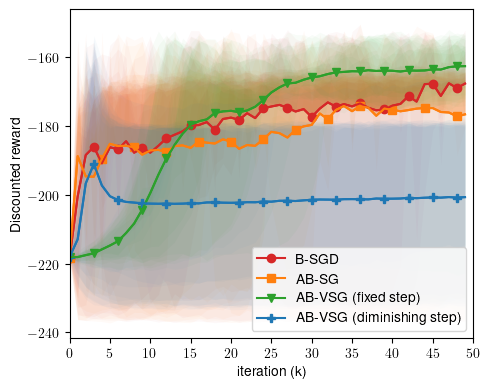

In [7]:
from matplotlib.ticker import MaxNLocator

num_iter = 50
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.mean(dis_reward_NBSGD, axis=0), color="C3", marker="o", markevery=3)
ax.plot(np.mean(dis_reward_ABSGD, axis=0), color="C1", marker="s", markevery=4)
ax.plot(np.mean(dis_reward_ABST, axis=0), color="C2", marker="v", markevery=3)
ax.plot(np.mean(dis_reward_ABSTD, axis=0), color="C0", marker="P", markevery=3)

plot_multiple_line(ax, range(num_iter), dis_reward_NBSGD, "C3", 0.03)
plot_multiple_line(ax, range(num_iter), dis_reward_ABSGD, "C1", 0.03)
plot_multiple_line(ax, range(num_iter), dis_reward_ABST, "C2", 0.03)
plot_multiple_line(ax, range(num_iter), dis_reward_ABSTD, "C0", 0.03)

ax.legend(("B-SGD", "AB-SG", "AB-VSG (fixed step)", "AB-VSG (diminishing step)"))
ax.set(xlabel="iteration (k)", xlim=[0, 50])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Discounted reward")
fig.tight_layout()
filename = "Figure/RL_reward.pdf"
plt.savefig(filename, bbox_inches="tight")


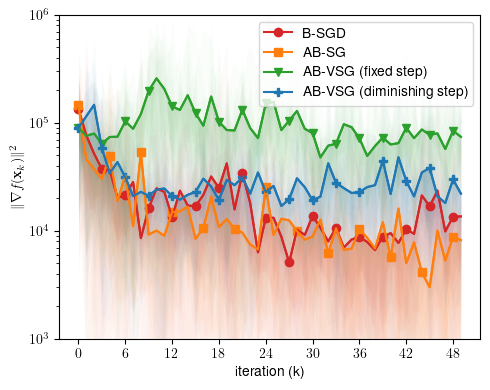

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.mean(grad_norm_NBSGD, axis=0), color="C3", marker="o", markevery=3)
ax.plot(np.mean(grad_norm_ABSGD, axis=0), color="C1", marker="s", markevery=4)
ax.plot(np.mean(grad_norm_ABST, axis=0), color="C2", marker="v", markevery=3)
ax.plot(np.mean(grad_norm_ABSTD, axis=0), color="C0", marker="P", markevery=3)

plot_multiple_line(ax, range(num_iter), grad_norm_NBSGD, "C3", 0.02)
plot_multiple_line(ax, range(num_iter), grad_norm_ABSGD, "C1", 0.02)
plot_multiple_line(ax, range(num_iter), grad_norm_ABST, "C2", 0.02)
plot_multiple_line(ax, range(num_iter), grad_norm_ABSTD, "C0", 0.02)
ax.legend(
    ("B-SGD", "AB-SG", "AB-VSG (fixed step)", "AB-VSG (diminishing step)"),
    loc="upper right",
)

ax.set(xlabel="iteration (k)", yscale="log")
ax.set(ylim=[1e3, 1e6])

ax.set_ylabel(r"$\|\nabla f(\mathbf{x}_k)\|^2$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
filename = "Figure/RL_grad.pdf"
plt.savefig(filename, bbox_inches="tight")


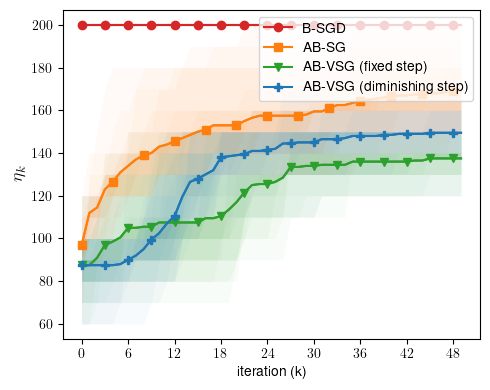

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.mean(H_NBSGD, axis=0), color="C3", marker="o", markevery=3)
ax.plot(np.mean(H_ABSGD, axis=0), color="C1", marker="s", markevery=4)
ax.plot(np.mean(H_ABST, axis=0), color="C2", marker="v", markevery=3)
ax.plot(np.mean(H_ABSTD, axis=0), color="C0", marker="P", markevery=3)

plot_multiple_line(ax, range(num_iter), H_NBSGD, "C3", 0.03)
plot_multiple_line(ax, range(num_iter), H_ABSGD, "C1", 0.03)
plot_multiple_line(ax, range(num_iter), H_ABST, "C2", 0.03)
plot_multiple_line(ax, range(num_iter), H_ABSTD, "C0", 0.03)
ax.legend(
    ("B-SGD", "AB-SG", "AB-VSG (fixed step)", "AB-VSG (diminishing step)"),
    loc="upper right",
)

ax.set(xlabel="iteration (k)")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylabel(r"$\eta_k$", fontsize=13)
fig.tight_layout()
filename = "Figure/RL_eta.pdf"
plt.savefig(filename, bbox_inches="tight")


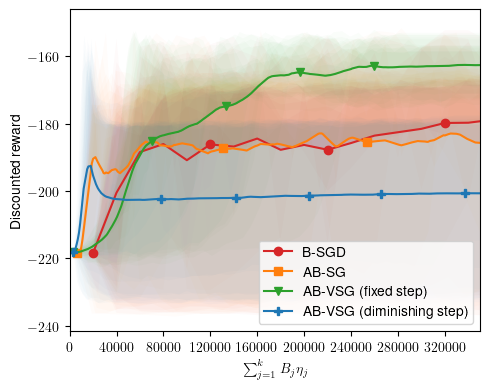

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_multiple_line(
    ax,
    np.cumsum(H_NBSGD * 100, axis=1),
    dis_reward_NBSGD,
    "C3",
    0.02,
    label="B-SGD",
    marker="o",
    markevery=5,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABSGD * 100, axis=1),
    dis_reward_ABSGD,
    "C1",
    0.02,
    label="AB-SG",
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABST * 50, axis=1),
    dis_reward_ABST,
    "C2",
    0.02,
    label="AB-VSG (fixed step)",
    marker="v",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABSTD * 50, axis=1),
    dis_reward_ABSTD,
    "C0",
    0.02,
    label="AB-VSG (diminishing step)",
    marker="P",
    markevery=100,
)

ax.legend(loc="lower right")

ax.set(xlabel=r"$\sum_{j=1}^k B_j \eta_j$", xlim=[0, 3.5e5])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Discounted reward")
fig.tight_layout()
filename = "Figure/RL_reward_eta.pdf"
plt.savefig(filename, bbox_inches="tight")


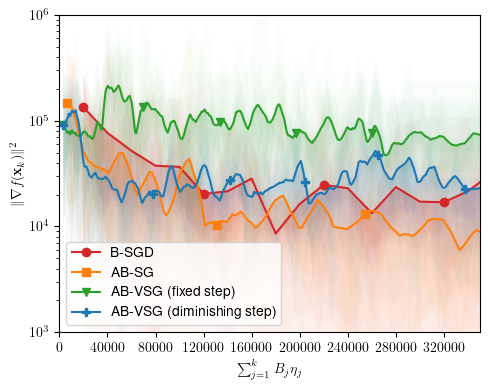

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_multiple_line(
    ax,
    np.cumsum(H_NBSGD * 100, axis=1),
    grad_norm_NBSGD,
    "C3",
    0.02,
    label="B-SGD",
    marker="o",
    markevery=5,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABSGD * 100, axis=1),
    grad_norm_ABSGD,
    "C1",
    0.02,
    label="AB-SG",
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABST * 50, axis=1),
    grad_norm_ABST,
    "C2",
    0.02,
    label="AB-VSG (fixed step)",
    marker="v",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(H_ABSTD * 50, axis=1),
    grad_norm_ABSTD,
    "C0",
    0.02,
    label="AB-VSG (diminishing step)",
    marker="P",
    markevery=100,
)

ax.legend()
ax.set(xlabel=r"$\sum_{j=1}^k B_j \eta_j$", yscale="log", xlim=[0, 3.5e5])
ax.set(ylim=[1e3, 1e6])
ax.set_ylabel(r"$\|\nabla f(\mathbf{x}_k)\|^2$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
filename = "Figure/RL_grad_eta.pdf"
plt.savefig(filename, bbox_inches="tight")


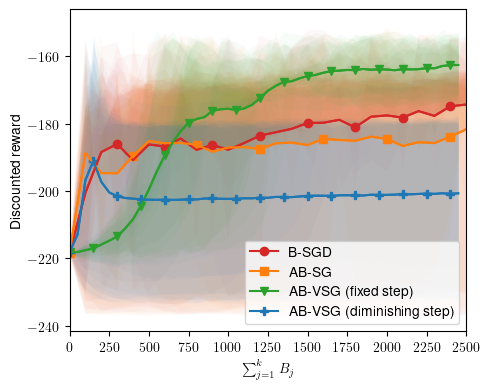

In [12]:
from matplotlib.ticker import MaxNLocator

num_iter = 50
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    range(0, num_iter * 100, 100),
    np.mean(dis_reward_NBSGD, axis=0),
    color="C3",
    marker="o",
    markevery=3,
)
ax.plot(
    range(0, num_iter * 100, 100),
    np.mean(dis_reward_ABSGD, axis=0),
    color="C1",
    marker="s",
    markevery=4,
)
ax.plot(
    range(0, num_iter * 50, 50),
    np.mean(dis_reward_ABST, axis=0),
    color="C2",
    marker="v",
    markevery=3,
)
ax.plot(
    range(0, num_iter * 50, 50),
    np.mean(dis_reward_ABSTD, axis=0),
    color="C0",
    marker="P",
    markevery=3,
)

plot_multiple_line(ax, range(0, num_iter * 100, 100),
                   dis_reward_NBSGD, "C3", 0.03)
plot_multiple_line(ax, range(0, num_iter * 100, 100),
                   dis_reward_ABSGD, "C1", 0.03)
plot_multiple_line(ax, range(0, num_iter * 50, 50),
                   dis_reward_ABST, "C2", 0.03)
plot_multiple_line(ax, range(0, num_iter * 50, 50),
                   dis_reward_ABSTD, "C0", 0.03)

ax.legend(("B-SGD", "AB-SG", "AB-VSG (fixed step)", "AB-VSG (diminishing step)"))
ax.set(xlabel=r"$\sum_{j=1}^k B_j$", xlim=[0, 2500])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Discounted reward")
fig.tight_layout()
filename = "Figure/RL_reward_batch.pdf"
plt.savefig(filename, bbox_inches="tight")


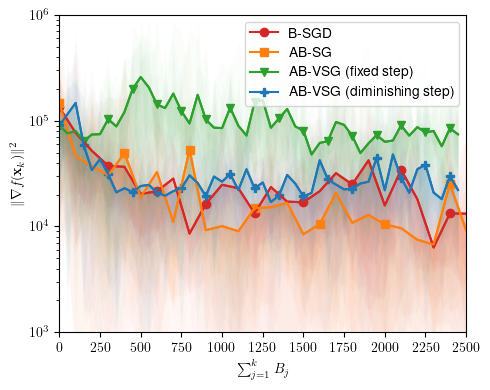

In [13]:
from matplotlib.ticker import MaxNLocator

num_iter = 50

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    np.arange(num_iter) * 100,
    np.mean(grad_norm_NBSGD, axis=0),
    color="C3",
    marker="o",
    markevery=3,
)
ax.plot(
    np.arange(num_iter) * 100,
    np.mean(grad_norm_ABSGD, axis=0),
    color="C1",
    marker="s",
    markevery=4,
)
ax.plot(
    np.arange(num_iter) * 50,
    np.mean(grad_norm_ABST, axis=0),
    color="C2",
    marker="v",
    markevery=3,
)
ax.plot(
    np.arange(num_iter) * 50,
    np.mean(grad_norm_ABSTD, axis=0),
    color="C0",
    marker="P",
    markevery=3,
)

plot_multiple_line(ax, range(0, num_iter * 100, 100),
                   grad_norm_NBSGD, "C3", 0.02)
plot_multiple_line(ax, range(0, num_iter * 100, 100),
                   grad_norm_ABSGD, "C1", 0.02)
plot_multiple_line(ax, range(0, num_iter * 50, 50), grad_norm_ABST, "C2", 0.02)
plot_multiple_line(ax, range(0, num_iter * 50, 50),
                   grad_norm_ABSTD, "C0", 0.02)
ax.legend(
    ("B-SGD", "AB-SG", "AB-VSG (fixed step)", "AB-VSG (diminishing step)"),
    loc="upper right",
)

ax.set(xlabel=r"$\sum_{j=1}^k B_j$", yscale="log")
ax.set(xlim=[0, 2500], ylim=[1e3, 1e6])

ax.set_ylabel(r"$\|\nabla f(\mathbf{x}_k)\|^2$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
filename = "Figure/RL_grad_batch.pdf"
plt.savefig(filename, bbox_inches="tight")
